<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-текста" data-toc-modified-id="Лемматизация-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#class_weight-=-'balanced'" data-toc-modified-id="class_weight-=-'balanced'-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>class_weight = 'balanced'</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LightGBM-Classifier" data-toc-modified-id="LightGBM-Classifier-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>LightGBM Classifier</a></span></li></ul></li><li><span><a href="#Функция-RandomUnderSampler-для-балансировки-классов-путем-уменьшения-мажоритарного-класса" data-toc-modified-id="Функция-RandomUnderSampler-для-балансировки-классов-путем-уменьшения-мажоритарного-класса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Функция RandomUnderSampler для балансировки классов путем уменьшения мажоритарного класса</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LightGBM-Classifier" data-toc-modified-id="LightGBM-Classifier-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>LightGBM Classifier</a></span></li></ul></li><li><span><a href="#Функция-SMOTE-для-балансировки-классов-путем-увеличения-меньшего-класса" data-toc-modified-id="Функция-SMOTE-для-балансировки-классов-путем-увеличения-меньшего-класса-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Функция SMOTE для балансировки классов путем увеличения меньшего класса</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LightGBM-Classifier" data-toc-modified-id="LightGBM-Classifier-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>LightGBM Classifier</a></span></li></ul></li></ul></li><li><span><a href="#тестирование-модели" data-toc-modified-id="тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Цель:** Обучить несколько моделей, выбрать лучшую, добиться значением метрики качества F1 не меньше 0.75. 
 В нашем распоряжении набор данных с разметкой о токсичности правок.


Работы выполним в 3 этапа

1. Загрузка и подготовка данных.
2. Обучение разных моделей. 
3. Выбор модели и проверка на тестовых данных.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip install -q pymystem3

In [2]:
#!pip install -q nltk

In [5]:
#!pip install -q imblearn

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

In [17]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:

import string
import warnings
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pymystem3 import Mystem

from tqdm import tqdm
from time import time

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

warnings.filterwarnings('ignore')
tqdm.pandas(desc='Processing Dataframe')
RNDST = 1234

In [7]:
try:
    data = pd.read_csv('/____________________/toxic_comments.csv')
except FileNotFoundError:
    data = pd.read_csv('toxic_comments.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [9]:
data.sample(5)

,Unnamed: 0,text,toxic
107567,107664,"""\n\nAncient history\n\nTalk:Wikipedia:Civilit...",0
80797,80873,"""\n\n Jackson \nWacko Jacko has only sold 170 ...",0
38940,38989,Linear B writing = Pelasgians language\n\nIf l...,0
158206,158365,Good Call\nWhoever organized the external link...,0
50602,50658,thanks fer new energy \n\ni have noticed a new...,0


In [10]:
# Удалим колонку дублирующую индексы
data = data.drop('Unnamed: 0', axis=1)

In [11]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Наблюдаем сильный дисбаланс классов почти 1 к 9.

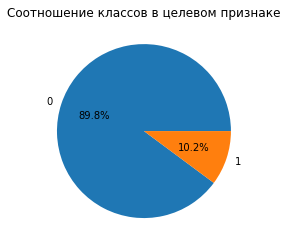

In [12]:
# посмотрим на количество строк с разными классами

plt.pie(data['toxic'].value_counts(), labels=data['toxic'].value_counts().index, autopct='%1.1f%%')

# подпись
plt.title('Соотношение классов в целевом признаке')

# выведем на экран
plt.show() 

### Лемматизация текста

In [13]:
# используя wordnet присвоим словам метку соответствующую части речи.
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def clean_text(text):
    # перевелем текст в нижний регистр
    text = text.lower()
    # уберем пунктуацию и разобьем текст на слова
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удалим ненужные слова, содержащие цифры
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удалим стоп слова 
    text = [x for x in text if x not in stopwords]
    # удалим пустые токены
    text = [t for t in text if len(t) > 0]
    # пометим части речи
    pos_tags = pos_tag(text)
    # лемматизируем текст для каждого слова найдем корневую форму.
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удалим слова состоящие из одной буквы
    text = [t for t in text if len(t) > 1]
    # объединим в текст
    text = " ".join(text)
    # в очищенный текст запишем слова содержащие буквы английского алфавита строчные и заглавные, разделим их пробелами
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return(text)


In [19]:
data['clean_text'] = data['text'].progress_apply(clean_text)

Processing Dataframe: 100%|██████████| 159292/159292 [05:06<00:00, 520.04it/s]


In [30]:
data.head()

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why edits make username hardcore m...
1,D'aww! He matches this background colour I'm s...,0,d aww match background colour i m seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really try edit war guy constantly...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make real suggestion improvement...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page that s


In [31]:
target = data['toxic']
feature = data['clean_text']

In [32]:
# до всех преобразований разделим данные на обучающую и тестовую выборки  
feature_train, feature_test, target_train, target_test = train_test_split(feature, 
                                                                              target, 
                                                                              test_size=0.10,
                                                                              stratify=target,
                                                                              shuffle=True, 
                                                                              random_state=RNDST)

In [33]:
# посмотрим на количество строк с разными классами
print('Размер тренировочной выборки:',feature_train.shape)
print('Размер тестовой выборки:',feature_test.shape)

Размер тренировочной выборки: (143362,)
Размер тестовой выборки: (15930,)


## Обучение

### class_weight = 'balanced'

In [27]:
#подготовим переменные для сбора данных

model_name = []
model_F1 = []
model_ROC_AUC = []
model_fit_time = []

In [28]:

#Будем проверять на адекватность наши модели с моделью которая генерирует ответы с учетом дисбаланса классов

dummy_clf = DummyClassifier(constant=0, random_state=RNDST, strategy='stratified')

dummy_clf.fit(feature_train, target_train)

predicted_dummy = dummy_clf.predict(feature_train)

dummy_f1_scores = f1_score(target_train, predicted_dummy)
dummy_roc_auc_score = roc_auc_score(target_train, dummy_clf.predict_proba(feature_train)[:, 1])

print("F1 мера DummyClassifier модели со случайными значениями:", dummy_f1_scores)

print()

print("AUC ROC DummyClassifier модели со случайными значениями:", dummy_roc_auc_score)


F1 мера DummyClassifier модели со случайными значениями: 0.10110123391269735

AUC ROC DummyClassifier модели со случайными значениями: 0.4998393536640773


#### LogisticRegression

In [29]:
pipeline_lr_balanced = Pipeline(
    [
        ("vect", TfidfVectorizer(norm="l2")),
        ("clf", LogisticRegression(class_weight='balanced')),
    ]
)
pipeline_lr_balanced

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [30]:
parameter_grid__lr = {
    "vect__max_df": (0.5, 0.7),    # процент документов в которых встречаются эти слова
    "vect__min_df": (3, 5),        # минимальное количество документов, которые должны содержать это слово
    "vect__ngram_range": ((1, 1), (1, 2)),
    "clf__solver": ('liblinear', 'lbfgs'),
    "clf__C": (6, 9, 12)
                    }

scoring = {"auc": "roc_auc", "f_1": "f1"}

In [31]:
rs_pipeline_lr_balanced = RandomizedSearchCV(
    estimator=pipeline_lr_balanced,
    param_distributions=parameter_grid__lr,
    n_iter=40,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)

start = time()
rs_pipeline_lr_balanced.fit(feature_train, target_train)
fit_time_rs_lr = time() - start

print('Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке:', 
      rs_pipeline_lr_balanced.best_score_)
print()
print('время обучения модели: %.2F секунд' %fit_time_rs_lr, '\n')
print('параметры модели для лучшего результата F1 меры на кросвалидационной выборке:', '\n',
      rs_pipeline_lr_balanced.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке: 0.7711976723672483

время обучения модели: 753.89 секунд 

параметры модели для лучшего результата F1 меры на кросвалидационной выборке: 
 {'vect__ngram_range': (1, 2), 'vect__min_df': 3, 'vect__max_df': 0.7, 'clf__solver': 'lbfgs', 'clf__C': 9}


In [32]:
lr_balanced_df = pd.DataFrame(rs_pipeline_lr_balanced.cv_results_
                 ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

In [33]:
lr_balanced_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,27.412352,10.842972,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.967295,0.771198
1,26.017189,11.728024,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.967295,0.771198
2,21.211163,10.241626,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.967291,0.771197
3,22.391991,11.406288,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.967291,0.771197
4,21.258325,10.937131,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.966733,0.770748


In [34]:
#Соберем данные для итоговой таблицы

model_name.append('LogisticRegression_class_weight_balanced')
model_F1.append(rs_pipeline_lr_balanced.best_score_)
model_fit_time.append(fit_time_rs_lr)
model_ROC_AUC.append(lr_balanced_df.mean_test_auc[0])

model_name

['LogisticRegression_class_weight_balanced']

#### DecisionTreeClassifier

In [35]:
pipeline_dtc_balanced = Pipeline(
    [
        ("vect", TfidfVectorizer(norm="l2")),
        ("dtc", DecisionTreeClassifier(min_samples_split=4,
                                       min_samples_leaf=2,
                                       class_weight='balanced')),
    ]
)
pipeline_dtc_balanced

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('dtc',
                 DecisionTreeClassifier(class_weight='balanced',
                                        min_samples_leaf=2,
                                        min_samples_split=4))])

In [36]:
parameter_grid__dtc = {
    "vect__max_df": (0.5, 0.7),
    "vect__min_df": (3, 5),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "dtc__max_depth": (20, 40, 60)
}



In [37]:
rs_pipeline_dtc_balanced = RandomizedSearchCV(
    estimator=pipeline_dtc_balanced,
    param_distributions=parameter_grid__dtc,
    n_iter=40,
    random_state=RNDST,
    n_jobs=-1,
    verbose=2,
    scoring=scoring,
    refit="f_1",
    cv=3
)

start = time()
rs_pipeline_dtc_balanced.fit(feature_train, target_train)
fit_time_rs_dtc = time() - start


print('Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке:', 
      rs_pipeline_dtc_balanced.best_score_)
print()
print('время обучения модели: %.2F секунд' %fit_time_rs_dtc, '\n')
print('параметры модели для лучшего результата F1 меры на кросвалидационной выборке:', '\n',
      rs_pipeline_dtc_balanced.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке: 0.6308278386601646

время обучения модели: 1144.10 секунд 

параметры модели для лучшего результата F1 меры на кросвалидационной выборке: 
 {'vect__ngram_range': (1, 1), 'vect__min_df': 5, 'vect__max_df': 0.7, 'dtc__max_depth': 40}


In [38]:
dtc_balanced_df = pd.DataFrame(rs_pipeline_dtc_balanced.cv_results_
                 ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)


In [39]:
dtc_balanced_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,34.934394,5.336501,"{'vect__ngram_range': (1, 1), 'vect__min_df': ...",0.817862,0.630828
1,35.296570,5.431610,"{'vect__ngram_range': (1, 1), 'vect__min_df': ...",0.816618,0.630309
2,37.195930,5.573624,"{'vect__ngram_range': (1, 1), 'vect__min_df': ...",0.815112,0.630286
3,36.629839,5.322571,"{'vect__ngram_range': (1, 1), 'vect__min_df': ...",0.814201,0.629821
4,80.092042,11.499355,"{'vect__ngram_range': (1, 2), 'vect__min_df': ...",0.811725,0.620661


In [40]:
#Соберем данные для итоговой таблицы

model_name.append('DecisionTreeClassifier_class_weight_balanced')
model_F1.append(rs_pipeline_dtc_balanced.best_score_)
model_fit_time.append(fit_time_rs_dtc)
model_ROC_AUC.append(dtc_balanced_df.mean_test_auc[0])

model_name

['LogisticRegression_class_weight_balanced',
 'DecisionTreeClassifier_class_weight_balanced']

#### LightGBM Classifier

In [41]:
from lightgbm import LGBMClassifier

In [42]:
pipeline_lgbm_balanced = Pipeline([("vect", TfidfVectorizer(norm="l1", ngram_range=(1, 1))),
                                   ("lgbm", LGBMClassifier(learning_rate=0.3, 
                                                           class_weight='balanced', 
                                                           n_estimators=500))])
pipeline_lgbm_balanced

Pipeline(steps=[('vect', TfidfVectorizer(norm='l1')),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.3,
                                n_estimators=500))])

In [43]:
parameter_grid__lgbm = {
    "lgbm__max_depth": (20, 30)
}

In [44]:
rs_pipeline_lgbm_balanced = RandomizedSearchCV(
    estimator=pipeline_lgbm_balanced,
    param_distributions=parameter_grid__lgbm,
    n_iter=20,
    random_state=RNDST,
    n_jobs=-1,
    verbose=2,
    scoring=scoring,
    refit="f_1",
    cv=3
)

start = time()
rs_pipeline_lgbm_balanced.fit(feature_train, target_train)
fit_time_rs_lgbm = time() - start

F1_rs_lgb = abs(rs_pipeline_lgbm_balanced.best_score_)

print('Лучший результат F1 меры модели LGBMClassifier на кросвалидационной выборке:', 
      rs_pipeline_lgbm_balanced.best_score_)
print()
print('время обучения модели: %.2F секунд' %fit_time_rs_lgbm, '\n')
print('параметры модели для лучшего результата F1 меры на кросвалидационной выборке:', '\n',
      rs_pipeline_lgbm_balanced.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Лучший результат F1 меры модели LGBMClassifier на кросвалидационной выборке: 0.7638197628886467

время обучения модели: 434.41 секунд 

параметры модели для лучшего результата F1 меры на кросвалидационной выборке: 
 {'lgbm__max_depth': 20}


In [45]:
lgbm_balanced_df = pd.DataFrame(rs_pipeline_lgbm_balanced.cv_results_
                 ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

lgbm_balanced_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,177.298676,13.952337,{'lgbm__max_depth': 20},0.955372,0.76382
1,163.808088,8.846916,{'lgbm__max_depth': 30},0.954485,0.76148


In [46]:
#Соберем данные для итоговой таблицы

model_name.append('LGBMClassifier_class_weight_balanced')
model_F1.append(rs_pipeline_lgbm_balanced.best_score_)
model_fit_time.append(fit_time_rs_lgbm)
model_ROC_AUC.append(lgbm_balanced_df.mean_test_auc[0])

model_name

['LogisticRegression_class_weight_balanced',
 'DecisionTreeClassifier_class_weight_balanced',
 'LGBMClassifier_class_weight_balanced']

In [47]:
# Соберем в датафрейм полученные результаты со всех моделей.

scores = pd.DataFrame( {'Name' : model_name, 
                       'f1_scores' : model_F1, 
                       'roc_auc' : model_ROC_AUC,
                       'fit_time' : model_fit_time}) 


scores.sort_values(by='f1_scores', ascending=False).reset_index(drop=True)

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
2,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445


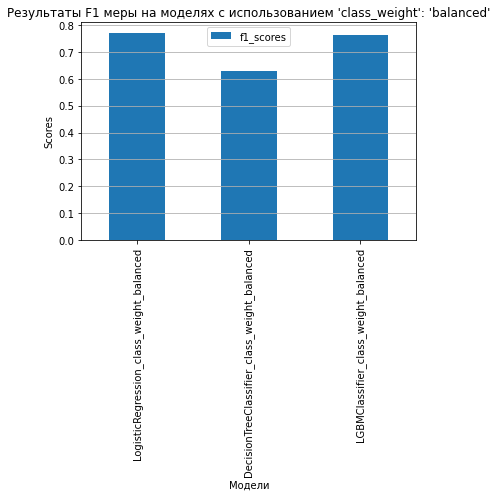

In [49]:
#результаты F1 меры на моделях с использованием 'class_weight': 'balanced'

ax = scores.plot.bar(y='f1_scores', 
                     x='Name', rot=90)


plt.xlabel("Модели")
plt.ylabel("Scores")
plt.title("Результаты F1 меры на моделях с использованием 'class_weight': 'balanced'")
plt.legend(["f1_scores"])
plt.grid(b=True, axis='y')

plt.show()

### Функция RandomUnderSampler для балансировки классов путем уменьшения мажоритарного класса

#### LogisticRegression

In [50]:

pipeline_lr_undersample = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)), 
                                        RandomUnderSampler(random_state=RNDST), 
                                        LogisticRegression())

pipeline_lr_undersample

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler(random_state=1234)),
                ('logisticregression', LogisticRegression())])

In [51]:
parameter_grid__pipe_lr_undersample = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "logisticregression__solver": ('liblinear', 'lbfgs'),
    "logisticregression__C": (6, 9, 12)
}

In [53]:
rs_pipeline_lr_undersample = RandomizedSearchCV(
    estimator=pipeline_lr_undersample,
    param_distributions=parameter_grid__pipe_lr_undersample,
    n_iter=40,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)

start = time()

rs_pipeline_lr_undersample.fit(feature_train, target_train)

fit_time_rs_lr_undersample = time() - start

print('Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке:', 
      rs_pipeline_lr_undersample.best_score_, '\n')

print('время обучения модели: %.2F секунд' %fit_time_rs_lr_undersample)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке: 0.6816716492314804 

время обучения модели: 221.93 секунд


In [54]:
rs_pipeline_lr_undersample_df = pd.DataFrame(rs_pipeline_lr_undersample.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_lr_undersample_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,7.030758,5.327749,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.963080,0.681672
1,6.608913,5.218382,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.963080,0.681672
2,6.907589,6.004016,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.963078,0.681601
3,6.237302,6.193576,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.963078,0.681601
4,6.489129,5.291295,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.962658,0.680118


In [55]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'LogisticRegression_undersample', 
          'f1_scores': rs_pipeline_lr_undersample.best_score_,
          'roc_auc': rs_pipeline_lr_undersample_df.mean_test_auc[0],
          'fit_time': fit_time_rs_lr_undersample
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [56]:
scores

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
3,LogisticRegression_undersample,0.681672,0.963080,221.933149


#### DecisionTreeClassifier

In [57]:

pipeline_dtc_undersample = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)), 
                                        RandomUnderSampler(random_state=RNDST), 
                                        DecisionTreeClassifier())

pipeline_dtc_undersample

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler(random_state=1234)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [58]:
parameter_grid__pipe_dtc_undersample = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "decisiontreeclassifier__max_depth": (20, 40, 60)
}

In [59]:
rs_pipeline_dtc_undersample = RandomizedSearchCV(
    estimator=pipeline_dtc_undersample,
    param_distributions=parameter_grid__pipe_dtc_undersample,
    n_iter=20,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)

start = time()

rs_pipeline_dtc_undersample.fit(feature_train, target_train)

fit_time_rs_dtc_undersample = time() - start

print('Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке:', 
      rs_pipeline_dtc_undersample.best_score_)

print('время обучения модели: %.2F секунд' %fit_time_rs_dtc_undersample)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке: 0.5676044994499526
время обучения модели: 139.49 секунд


In [60]:
rs_pipeline_dtc_undersample_df = pd.DataFrame(rs_pipeline_dtc_undersample.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_dtc_undersample_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,9.180542,4.997384,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.838002,0.567604
1,6.721504,5.197808,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.826435,0.566792
2,6.871916,4.974868,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.826262,0.565412
3,7.039385,5.203733,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.825366,0.564267
4,7.213036,5.390371,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.825483,0.564025


In [61]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'DecisionTreeClassifier_undersample', 
          'f1_scores': rs_pipeline_dtc_undersample.best_score_,
          'roc_auc': rs_pipeline_dtc_undersample_df.mean_test_auc[0],
          'fit_time': fit_time_rs_dtc_undersample
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [62]:
scores

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
3,LogisticRegression_undersample,0.681672,0.963080,221.933149
4,DecisionTreeClassifier_undersample,0.567604,0.838002,139.489653


#### LightGBM Classifier

In [63]:

pipeline_lgbm_undersample = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)),
                                         RandomUnderSampler(random_state=RNDST),
                                         LGBMClassifier(learning_rate=0.3,
                                                        n_estimators=500))

pipeline_lgbm_undersample

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler(random_state=1234)),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.3, n_estimators=500))])

In [64]:
parameter_grid__pipe_lgbm_undersample = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "lgbmclassifier__max_depth": (20, 50, 70)
}

In [65]:
rs_pipeline_lgbm_undersample = RandomizedSearchCV(
    estimator=pipeline_lgbm_undersample,
    param_distributions=parameter_grid__pipe_lgbm_undersample,
    n_iter=20,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)
start = time()
rs_pipeline_lgbm_undersample.fit(feature_train, target_train)

fit_time_rs_lgbm_undersample = time() - start

print('Лучший результат F1 меры модели LGBMClassifier() на кросвалидационной выборке:', 
      rs_pipeline_lgbm_undersample.best_score_, '\n')

print('время обучения модели: %.2F секунд' %fit_time_rs_lgbm_undersample)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучший результат F1 меры модели LGBMClassifier() на кросвалидационной выборке: 0.6337040130181486 

время обучения модели: 549.77 секунд


In [66]:
rs_pipeline_lgbm_undersample_df = pd.DataFrame(rs_pipeline_lgbm_undersample.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_lgbm_undersample_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,40.373358,14.698899,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.951164,0.633704
1,40.672281,13.276226,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.951164,0.633704
2,40.976344,13.258353,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.950761,0.632604
3,39.366619,12.635460,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.950761,0.632604
4,46.748973,13.355439,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.950278,0.630051


In [67]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'LGBMClassifier_undersample', 
          'f1_scores': rs_pipeline_lgbm_undersample.best_score_,
          'roc_auc': rs_pipeline_lgbm_undersample_df.mean_test_auc[0],
          'fit_time': fit_time_rs_lgbm_undersample
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [68]:
scores

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
3,LogisticRegression_undersample,0.681672,0.963080,221.933149
4,DecisionTreeClassifier_undersample,0.567604,0.838002,139.489653
5,LGBMClassifier_undersample,0.633704,0.951164,549.766629


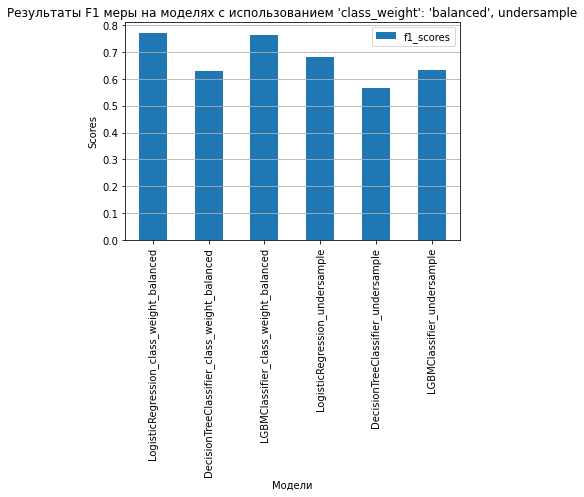

In [69]:
#результаты F1 меры на моделях с использованием 'class_weight': 'balanced', undersample

ax = scores.plot.bar(y='f1_scores', 
                     x='Name',
                     rot=90)



plt.xlabel("Модели")
plt.ylabel("Scores")
plt.title("Результаты F1 меры на моделях с использованием 'class_weight': 'balanced', undersample")
plt.legend(["f1_scores"])
plt.grid(b=True, axis='y')

plt.show()

### Функция SMOTE для балансировки классов путем увеличения меньшего класса

#### LogisticRegression

In [70]:

pipeline_lr_smote = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)), 
                                        SMOTE(random_state=RNDST), 
                                        LogisticRegression())

pipeline_lr_smote

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=1234)),
                ('logisticregression', LogisticRegression())])

In [71]:
parameter_grid__pipe_lr_smote = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "logisticregression__solver": ('liblinear', 'lbfgs'),
    "logisticregression__C": (6, 9, 12)
}

In [72]:
rs_pipeline_lr_smote = RandomizedSearchCV(
    estimator=pipeline_lr_smote,
    param_distributions=parameter_grid__pipe_lr_smote,
    n_iter=40,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)
start = time()
rs_pipeline_lr_smote.fit(feature_train, target_train)

fit_time_rs_pipeline_lr_smote = time() - start

print('Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке:', 
      rs_pipeline_lr_smote.best_score_, '\n')
print('время обучения модели: %.2F секунд' %fit_time_rs_pipeline_lr_smote)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучший результат F1 меры модели LogisticRegression на кросвалидационной выборке: 0.6663784278410996 

время обучения модели: 361.42 секунд


In [73]:
rs_pipeline_lr_smote_df = pd.DataFrame(rs_pipeline_lr_smote.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_lr_smote_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,15.228097,5.530862,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.946335,0.666378
1,15.071003,5.181928,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.946335,0.666378
2,11.955928,4.848616,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.946350,0.666212
3,12.318650,5.199034,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.946350,0.666212
4,14.410447,5.322542,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.945600,0.664715


In [74]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'LogisticRegression_SMOTE', 
          'f1_scores': rs_pipeline_lr_smote.best_score_,
          'roc_auc': rs_pipeline_lr_smote_df.mean_test_auc[0],
          'fit_time': fit_time_rs_pipeline_lr_smote
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [75]:
scores

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
3,LogisticRegression_undersample,0.681672,0.963080,221.933149
4,DecisionTreeClassifier_undersample,0.567604,0.838002,139.489653
5,LGBMClassifier_undersample,0.633704,0.951164,549.766629
6,LogisticRegression_SMOTE,0.666378,0.946335,361.421563


#### DecisionTreeClassifier

In [76]:

pipeline_dtc_smote = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)), 
                                        SMOTE(random_state=RNDST), 
                                        DecisionTreeClassifier())

pipeline_dtc_smote

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=1234)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [77]:
parameter_grid__pipe_dtc_smote = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "decisiontreeclassifier__max_depth": (20, 40, 60)
}

In [78]:
rs_pipeline_dtc_smote = RandomizedSearchCV(
    estimator=pipeline_dtc_smote,
    param_distributions=parameter_grid__pipe_dtc_smote,
    n_iter=20,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)
start = time()
rs_pipeline_dtc_smote.fit(feature_train, target_train)

fit_time_rs_pipeline_dtc_smote = time() - start

print('Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке:', 
      rs_pipeline_dtc_smote.best_score_, '\n')

print('время обучения модели: %.2F секунд' %fit_time_rs_pipeline_dtc_smote)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучший результат F1 меры модели DecisionTreeClassifier на кросвалидационной выборке: 0.6076279643664159 

время обучения модели: 776.63 секунд


In [79]:
rs_pipeline_dtc_smote_df = pd.DataFrame(rs_pipeline_dtc_smote.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_dtc_smote_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,101.831246,4.359073,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.803050,0.607628
1,105.759099,5.588149,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.801378,0.607424
2,102.235319,5.358999,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.799539,0.605679
3,105.627095,5.572526,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.798786,0.603440
4,75.428860,5.327750,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.806666,0.602310


In [80]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'DecisionTreeClassifier_SMOTE', 
          'f1_scores': rs_pipeline_dtc_smote.best_score_,
          'roc_auc': rs_pipeline_dtc_smote_df.mean_test_auc[0],
          'fit_time': fit_time_rs_pipeline_dtc_smote
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [81]:
scores

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
3,LogisticRegression_undersample,0.681672,0.963080,221.933149
4,DecisionTreeClassifier_undersample,0.567604,0.838002,139.489653
5,LGBMClassifier_undersample,0.633704,0.951164,549.766629
6,LogisticRegression_SMOTE,0.666378,0.946335,361.421563
7,DecisionTreeClassifier_SMOTE,0.607628,0.803050,776.629099


#### LightGBM Classifier

In [82]:

pipeline_lgbm_smote = make_pipeline(TfidfVectorizer(norm="l2", ngram_range=(1, 1)),
                                         SMOTE(random_state=RNDST),
                                         LGBMClassifier(learning_rate=0.3,
                                                        n_estimators=500))

pipeline_lgbm_smote

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=1234)),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.3, n_estimators=500))])

In [83]:
parameter_grid__pipe_lgbm_smote = {
    "tfidfvectorizer__max_df": (0.5, 0.7),
    "tfidfvectorizer__min_df": (3, 5),
    "lgbmclassifier__max_depth": (20, 50, 70)
}

In [84]:
rs_pipeline_lgbm_smote = RandomizedSearchCV(
    estimator=pipeline_lgbm_smote,
    param_distributions=parameter_grid__pipe_lgbm_smote,
    n_iter=20,
    random_state=RNDST,
    n_jobs=-1,
    verbose=3,
    scoring=scoring,
    refit="f_1",
    cv=3
)
start = time()
rs_pipeline_lgbm_smote.fit(feature_train, target_train)

fit_time_rs_pipeline_lgbm_smote = time() - start

print('Лучший результат F1 меры модели LGBMClassifier() на кросвалидационной выборке:', 
      rs_pipeline_lgbm_smote.best_score_)


print('время обучения модели: %.2F секунд' %fit_time_rs_pipeline_lgbm_smote)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучший результат F1 меры модели LGBMClassifier() на кросвалидационной выборке: 0.7589363786487957
время обучения модели: 2987.02 секунд


In [85]:
rs_pipeline_lgbm_smote_df = pd.DataFrame(rs_pipeline_lgbm_smote.cv_results_
                                            ).sort_values(by='mean_test_f_1',ascending=False).reset_index(drop=True)

rs_pipeline_lgbm_smote_df[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_auc', 'mean_test_f_1']].head()

,mean_fit_time,mean_score_time,params,mean_test_auc,mean_test_f_1
0,279.955911,13.952147,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.952074,0.758936
1,278.532074,13.436557,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.952074,0.758936
2,277.285825,13.672244,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.951569,0.751913
3,275.970517,13.350597,"{'tfidfvectorizer__min_df': 5, 'tfidfvectorize...",0.951569,0.751913
4,313.224733,15.155186,"{'tfidfvectorizer__min_df': 3, 'tfidfvectorize...",0.952429,0.746855


In [86]:
# добавим данные в итоговую таблицу
dicts = [{'Name': 'LightGBM Classifier_SMOTE', 
          'f1_scores': rs_pipeline_lgbm_smote.best_score_,
          'roc_auc': rs_pipeline_lgbm_smote_df.mean_test_auc[0],
          'fit_time': fit_time_rs_pipeline_lgbm_smote
         }]
        
scores = scores.append(dicts, ignore_index=True, sort=False)

In [87]:
scores.sort_values('f1_scores', ascending=False)

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
8,LightGBM Classifier_SMOTE,0.758936,0.952074,2987.016736
3,LogisticRegression_undersample,0.681672,0.963080,221.933149
6,LogisticRegression_SMOTE,0.666378,0.946335,361.421563
5,LGBMClassifier_undersample,0.633704,0.951164,549.766629
1,DecisionTreeClassifier_class_weight_balanced,0.630828,0.817862,1144.100445
7,DecisionTreeClassifier_SMOTE,0.607628,0.803050,776.629099
4,DecisionTreeClassifier_undersample,0.567604,0.838002,139.489653


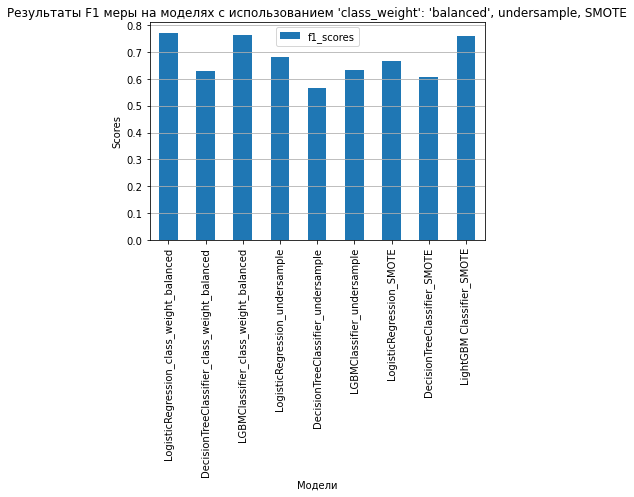

In [88]:
#результаты F1 меры на моделях с использованием 'class_weight': 'balanced', undersample, SMOTE

ax = scores.plot.bar(y='f1_scores', 
                     x='Name',
                     rot=90)



plt.xlabel("Модели")
plt.ylabel("Scores")
plt.title("Результаты F1 меры на моделях с использованием 'class_weight': 'balanced', undersample, SMOTE")
plt.legend(["f1_scores"])
plt.grid(b=True, axis='y')

plt.show()

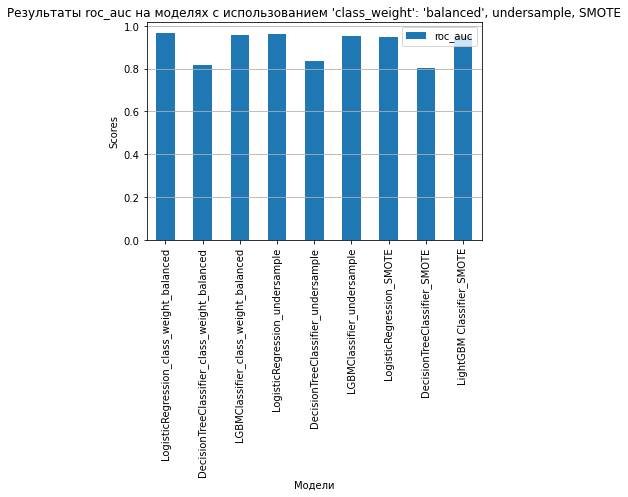

In [89]:
#результаты roc_auc на моделях с использованием 'class_weight': 'balanced', undersample, SMOTE

ax = scores.plot.bar(y='roc_auc', x='Name', rot=90)

plt.xlabel("Модели")
plt.ylabel("Scores")
plt.title("Результаты roc_auc на моделях с использованием 'class_weight': 'balanced', undersample, SMOTE")

plt.grid(b=True, axis='y')

plt.show()

Все модели отработали лучше чем DummyClassifier которая генерировала ответы соблюдая соотношение классов.

У нас получились примерно одинаковые значения F1 меры на моделях LogisticRegression с автоматической балансировкой классов при обучении и LGBMClassifier с автоматической балансировкой и балансировкой классов путем увеличения меньшего класса.
Все три модели переступили заданный рубеж 0,75. При этом модель LogisticRegression_class_weight_balanced показала результаты чуть лучше остальных трех и в метрике F1 и roc_auc. Проверим ее на тестовых данных

In [90]:
scores.loc[scores['Name'].isin(['LogisticRegression_class_weight_balanced',
                                'LGBMClassifier_class_weight_balanced', 
                                'LightGBM Classifier_SMOTE'])]

,Name,f1_scores,roc_auc,fit_time
0,LogisticRegression_class_weight_balanced,0.771198,0.967295,753.891382
2,LGBMClassifier_class_weight_balanced,0.763820,0.955372,434.413973
8,LightGBM Classifier_SMOTE,0.758936,0.952074,2987.016736


## тестирование модели

In [95]:
rs_pipeline_lr_balanced_test = f1_score(target_test, rs_pipeline_lr_balanced.predict(feature_test))
rfc_balance_roc_auc_score_test = roc_auc_score(target_test, rs_pipeline_lr_balanced.predict(feature_test))


In [96]:
print('Лучший результат F1 меры модели RandomForestClassifier на тестовой выборке:', rs_pipeline_lr_balanced_test)
print()
print("AUC ROC модели RandomForestClassifier на тестовой выборке:", rfc_balance_roc_auc_score_test)

Лучший результат F1 меры модели RandomForestClassifier на тестовой выборке: 0.7759838546922301

AUC ROC модели RandomForestClassifier на тестовой выборке: 0.8818215707119539


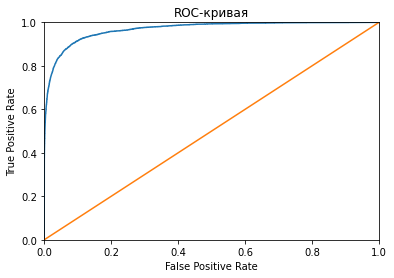

In [97]:
# Вычислим вероятности классов
probabilities_test = rs_pipeline_lr_balanced.predict_proba(feature_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# Построим ROC кривую
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Выводы

Перед нами стояла задача: Обучить модель классифицировать комментарии на позитивные и негативные.

Цель: Обучить несколько моделей, выбрать лучшую, добиться значением метрики качества F1 не меньше 0.75. В нашем распоряжении набор данных с разметкой о токсичности правок.

Работы выполнили в 3 этапа

1. Загрузка и подготовка данных.
2. Обучение разных моделей.
3. Выбор модели и проверка на тестовых данных.

В ходе подготовки данных 
1. написали собственную функцию с помощью которой привели к строчным буквам все слова, убрали знаки пунктуации, удалили стоп слова, лемматизировали слова в тексте. 
2. обнаружили дисбаланс в целевом признаке примерно в соотношении 1:9 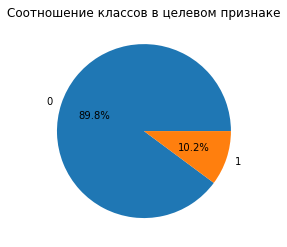
3. разделили данные на тренировочную и тестовую выборки с сохранением дисбаланса классов.                                   

Для обучения выбрали модели 
* LogisticRegression 
* LGBMClassifier 
* DecisionTreeClassifier
Векторизацию данных выполнили при помощи TfidfVectorizer в make_pipeline.
Параметры моделей и TfidfVectorizer перебирали при помощи RandomizedSearchCV

Для работы с дисбалансом классов выбрали следующие методы:
1. Выполнили автоматическую балансировку классов при помощи 'class_weight': 'balanced'
2. Использовали функцию RandomUnderSampler для балансировки классов путем уменьшения мажоритарного класса
3. Выполнили балансировку классов путем увеличения меньшего класса с помощью функции SMOTE
4. Для проверки на адекватность использовали DummyClassifier, которая генерировала ответы соблюдая соотношение классов
 



Все модели отработали лучше чем DummyClassifier 

Получились примерно одинаковые значения F1 меры на моделях 
* LogisticRegression с автоматической балансировкой классов 
* LGBMClassifier с автоматической балансировкой классов
* LGBMClassifier балансировкой классов путем увеличения меньшего класса.

Все три модели переступили заданный рубеж 0,75 для F1. При этом модель LogisticRegression_class_weight_balanced показала результаты чуть лучше остальных трех и в метрике F1 и roc_auc. 

Модель LogisticRegression с автоматической балансировкой классов проверили на тестовой выборке с результатом 
* F1: 0.7759838546922301 
* AUC ROC: 0.8818215707119539

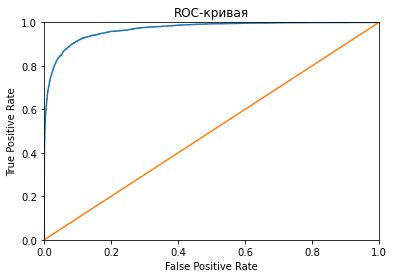


Метрика F1 превышает необходимый рубеж 0,75 заданный условием проекта.
Цели и задачи проекта выполнены.